## Imports and Data Loading

We begin by importing necessary modules/functions and load our scaled data from the [`data\processed`](<..\data\processed>) directory.

In [24]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, LSTM, Reshape
from tensorflow.keras.regularizers import l2

# load data
scaled_data = pd.read_csv(os.path.join('..', 'data', 'processed', 'scaled_data.csv'), index_col= ['Date'])

display(scaled_data)

,PE,M2,CPI,_MKT
Date,,,,
1988-04-10,0.095785,0.303164,0.629228,0.001175
1988-04-17,0.076628,0.309296,0.611069,0.000463
1988-04-24,0.076628,0.309296,0.611069,0.000465
1988-05-01,0.080460,0.309296,0.611069,0.000606
1988-05-08,0.072797,0.309296,0.611069,0.000296
...,...,...,...,...
2024-04-07,0.620690,0.134544,0.534995,0.990466
2024-04-14,0.605364,0.158827,0.455907,0.974132
2024-04-21,0.578544,0.158827,0.455907,0.943699


## Implementing the Network Architecture

We create a lagged dataset again and implement the network architecture we refined previously.

In [25]:
def create_lagged_dataset(data, lag):
    X, y = [], []
    for i in range(len(data) - lag):
        X.append(data.iloc[i:(i + lag)].values)
        y.append(data.iloc[i + lag]['_MKT'])
    return np.array(X), np.array(y)

# lagged dataset
lag = 4 # use prev 4 week data to predict (approx. 1 month)
X, y = create_lagged_dataset(scaled_data, lag=lag)

# time-based split (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f'Training data shape: {X_train.shape}')
print(f'Testing data shape: {X_test.shape}')

# input shape
input_shape = (X.shape[1], X.shape[2])

Training data shape: (1503, 4, 4)
Testing data shape: (376, 4, 4)


In [26]:
# fxn to create and compile the model
def create_model(input_shape, filters, kernel_sizes):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=filters[0], kernel_size=kernel_sizes[0], activation='relu')(inputs)
    x = Conv1D(filters=filters[1], kernel_size=kernel_sizes[1], activation='relu')(x)
    x = Conv1D(filters=filters[2], kernel_size=kernel_sizes[2], activation='relu')(x)
    x = Flatten()(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dense(8, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Reshape((8, 1))(x)
    x = LSTM(50, return_sequences=True)(x)
    x = LSTM(50)(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

## Conifiguring the Model

We continue by testing the architecture with varying filter configurations, but set kernel size to 2 (this is because we use the CNN part of our network to capture short-term trends).

We output the evaluations of the various filter configurations in [`models`](<..\models>).

In [27]:
filter_results = []

# filters to test
filter_configs = [
    [8, 16, 32],
    [16, 32, 64],
    [32, 64, 128]
]

for filters in filter_configs:
    print(f'Training model with filters: {filters}')
    model = create_model(input_shape, filters, kernel_sizes=[2, 2, 2])
    history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test), verbose=0)
    
    # predict
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    # eval
    in_sample_mse = mean_squared_error(y_train, train_predictions)
    out_sample_mse = mean_squared_error(y_test, test_predictions)
    in_sample_rmse = np.sqrt(in_sample_mse)
    out_sample_rmse = np.sqrt(out_sample_mse)
    in_sample_mae = mean_absolute_error(y_train, train_predictions)
    out_sample_mae = mean_absolute_error(y_test, test_predictions)
    in_sample_mape = mean_absolute_percentage_error(y_train, train_predictions)
    out_sample_mape = mean_absolute_percentage_error(y_test, test_predictions)
    in_sample_r2 = r2_score(y_train, train_predictions)
    out_sample_r2 = r2_score(y_test, test_predictions)
    
    filter_results.append({
        'filters': filters,
        'in_sample_mse': in_sample_mse,
        'out_sample_mse': out_sample_mse,
        'in_sample_rmse': in_sample_rmse,
        'out_sample_rmse': out_sample_rmse,
        'in_sample_mae': in_sample_mae,
        'out_sample_mae': out_sample_mae,
        'in_sample_mape': in_sample_mape,
        'out_sample_mape': out_sample_mape,
        'in_sample_r2': in_sample_r2,
        'out_sample_r2': out_sample_r2
    })

# output
filter_df = pd.DataFrame(filter_results)
filter_df.to_csv(os.path.join('..', 'models', 'filters_configuration.csv'), index=False)

display(filter_df)

Training model with filters: [8, 16, 32]
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Training model with filters: [16, 32, 64]
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Training model with filters: [32, 64, 128]
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,filters,in_sample_mse,out_sample_mse,in_sample_rmse,out_sample_rmse,in_sample_mae,out_sample_mae,in_sample_mape,out_sample_mape,in_sample_r2,out_sample_r2
0,"[8, 16, 32]",0.009764,0.287611,0.098814,0.536294,0.077083,0.509781,4.084658e+11,0.774101,-0.001494,-9.370241
1,"[16, 32, 64]",0.000043,0.002109,0.006573,0.045928,0.005488,0.032975,2.180452e+08,0.047207,0.995569,0.923944
2,"[32, 64, 128]",0.000103,0.006545,0.010157,0.080902,0.008585,0.059371,2.784957e+10,0.083231,0.989418,0.764006


## Finalizing the Model

We can clearly see that the filter configuration [16, 32, 64] performs best and proceeed forward with the implementation of our trading strategies.

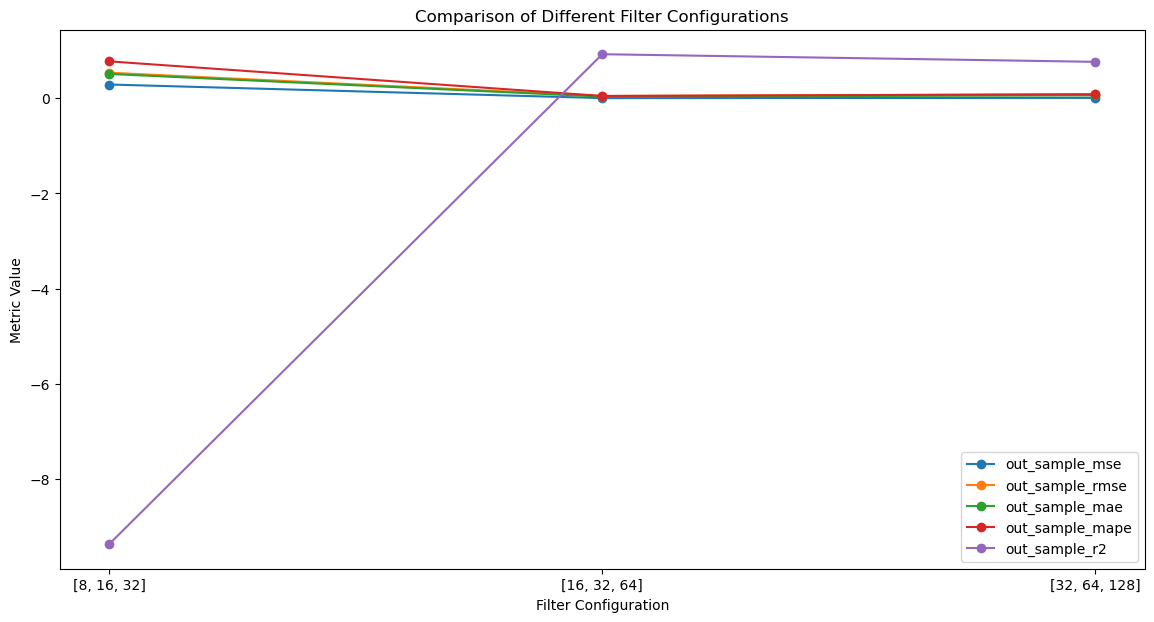

In [28]:
# plot
plt.figure(figsize=(14, 7))
for metric in ['out_sample_mse', 'out_sample_rmse', 'out_sample_mae', 'out_sample_mape', 'out_sample_r2']:
    plt.plot(filter_df['filters'].apply(str), filter_df[metric], marker='o', label=metric)
plt.xlabel('Filter Configuration')
plt.ylabel('Metric Value')
plt.title('Comparison of Different Filter Configurations')
plt.legend()
plt.show()